In [292]:
!python -V

import pandas as pd
import numpy as np  

import seaborn as sns
import matplotlib.pyplot as plt
import json

import matplotlib.pyplot as plt

Python 3.9.12


In [293]:
import argparse
import os
import pickle

In [379]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

!pipenv install xgboost
!pipenv install hyperopt

import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.
Installing xgboost...
Adding xgboost to Pipfile's [packages]...
✔ Installation Succeeded 
Pipfile.lock (81aa38) out of date, updating to (80358f)...
Locking [dev-packages] dependencies...
Locking [packages] dependencies...
Building requirements...
Resolving dependencies...
✘ Locking Failed! 

CRITICAL:pipenv.patched.notpip._internal.resolution.resolvelib.factory:Could not find a version that satisfies the requirement json (from versions: none)
[ResolutionFailure]:   File "/usr/local/Cellar/pipenv/2022.6.7/libexec/lib/python3.10/site-packages/pipenv/resolver.py", line 822, in _main
[ResolutionFailure]:       resolve_packages(
[ResolutionFailure]:   File "/u

In [258]:
import mlflow
 
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("glucose-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='glucose-experiment', tags={}>

In [376]:
def dump_pickle(obj, filename):
    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)


def read_dataframe(filename: str):
    # load file
    data = pd.read_json(filename)
    # Rearrange cols
    cols = pd.Series(data.wn_interpolated[0]).astype(int)
    list_arrays = list(data.spectrum_interpolated)

    data = pd.DataFrame(data=list_arrays, columns=cols, index=data.glucose).reset_index()
    
    
    data = pd.melt(data, id_vars=['glucose','experiment_number'], value_vars=data.iloc[:,2:].columns)
    data.experiment_number = data.experiment_number.apply(lambda x: x+1) 

    return data


def preprocess(df: pd.DataFrame, dv: DictVectorizer, fit_dv: bool = False):
    features = ['variable','value']
    dicts = data[features].to_dict(orient='records')
    dicts
    if fit_dv:
        X = dv.fit_transform(dicts)
    else:
        X = dv.transform(dicts)
    return X, dv


In [ ]:
def run(data_path: str, data_dest: str, dataset: str):
    # load json file
    data = pd.read_json('./dataset.json')

    cols = pd.Series(data.wn_interpolated[0]).astype(int)
    list_arrays = list(data.spectrum_interpolated)

    data = pd.DataFrame(data=list_arrays, columns=cols, index=data.glucose).reset_index()

    data.index = data.index.set_names(['experiment_number'])
    data.reset_index(inplace=True)


    data = pd.melt(data, id_vars=['glucose','experiment_number'], value_vars=data.iloc[:,2:].columns)
    data.experiment_number = data.experiment_number.apply(lambda x: x+1) 


    data_train = data[data.experiment_number <= data.experiment_number.max()*0.70]
    data_val = data[(data.experiment_number > data.experiment_number.max()*0.70) & (data.experiment_number <= data.experiment_number.max()*0.85)]
    data_test = data[data.experiment_number > data.experiment_number.max()*0.85]   
    
    # extract the target
    target = 'glucose'
    y_train = data_train[target].values
    y_val = data_val[target].values
    y_test = data_test[target].values

        # fit the dictvectorizer and preprocess data
    dv = DictVectorizer()
    X_train, dv = preprocess(data_train, dv, fit_dv=True)
    X_val, _ = preprocess(data_valid, dv, fit_dv=False)
    X_test, _ = preprocess(data_test, dv, fit_dv=False)

    # create dest_path folder unless it already exists
    os.makedirs(dest_path, exist_ok=True)

    # save dictvectorizer and datasets
    dump_pickle(dv, os.path.join(dest_path, "dv.pkl"))
    dump_pickle((X_train, y_train), os.path.join(dest_path, "train.pkl"))
    dump_pickle((X_valid, y_valid), os.path.join(dest_path, "valid.pkl"))
    dump_pickle((X_test, y_test), os.path.join(dest_path, "test.pkl"))


    
     

In [371]:
data

,experiment_number,glucose,950,951,952,953,954,955,956,957,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,0,180,0.005445,0.005084,0.004748,0.004435,0.004140,0.003857,0.003587,0.003337,...,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960
1,1,160,0.005118,0.004855,0.004609,0.004379,0.004159,0.003944,0.003737,0.003544,...,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330
2,2,90,0.001874,0.002117,0.002358,0.002590,0.002806,0.003002,0.003178,0.003340,...,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111
3,3,90,0.001911,0.001861,0.001826,0.001804,0.001790,0.001774,0.001757,0.001744,...,0.003498,0.003498,0.003498,0.003498,0.003498,0.003498,0.003498,0.003498,0.003498,0.003498
4,4,110,0.003414,0.003461,0.003512,0.003563,0.003609,0.003643,0.003668,0.003689,...,0.005399,0.005399,0.005399,0.005399,0.005399,0.005399,0.005399,0.005399,0.005399,0.005399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1915,185,0.001706,0.001735,0.001776,0.001832,0.001893,0.001950,0.002000,0.002049,...,0.003898,0.003898,0.003898,0.003898,0.003898,0.003898,0.003898,0.003898,0.003898,0.003898
1916,1916,180,0.006960,0.006720,0.006483,0.006248,0.006009,0.005764,0.005515,0.005271,...,0.006838,0.006838,0.006838,0.006838,0.006838,0.006838,0.006838,0.006838,0.006838,0.006838
1917,1917,155,0.000638,0.000834,0.001038,0.001246,0.001450,0.001641,0.001816,0.001981,...,0.004305,0.004305,0.004305,0.004305,0.004305,0.004305,0.004305,0.004305,0.004305,0.004305
1918,1918,195,0.001597,0.001607,0.001636,0.001684,0.001741,0.001798,0.001853,0.001911,...,0.003423,0.003423,0.003423,0.003423,0.003423,0.003423,0.003423,0.003423,0.003423,0.003423


In [ ]:
def run(raw_data_path: str, dest_path: str, dataset: str):
    # load parquet files
    df_train = read_json(
        os.path.join(raw_data_path, f"{dataset}.json")
    )
    df_valid = read_json(
        os.path.join(raw_data_path, f"{dataset}.json")
    )
    df_test = read_json(
        os.path.join(raw_data_path, f"{dataset}.json")
    )

    # extract the target
    target = 'duration'
    y_train = df_train[target].values
    y_valid = df_valid[target].values
    y_test = df_test[target].values

    # fit the dictvectorizer and preprocess data
    dv = DictVectorizer()
    X_train, dv = preprocess(df_train, dv, fit_dv=True)
    X_valid, _ = preprocess(df_valid, dv, fit_dv=False)
    X_test, _ = preprocess(df_test, dv, fit_dv=False)

    # create dest_path folder unless it already exists
    os.makedirs(dest_path, exist_ok=True)

    # save dictvectorizer and datasets
    dump_pickle(dv, os.path.join(dest_path, "dv.pkl"))
    dump_pickle((X_train, y_train), os.path.join(dest_path, "train.pkl"))
    dump_pickle((X_valid, y_valid), os.path.join(dest_path, "valid.pkl"))
    dump_pickle((X_test, y_test), os.path.join(dest_path, "test.pkl"))


if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--raw_data_path",
        help="the location where the raw NYC taxi trip data was saved"
    )
    parser.add_argument(
        "--dest_path",
        help="the location where the resulting files will be saved."
    )
    args = parser.parse_args()

    run(args.raw_data_path, args.dest_path)


In [ ]:
def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


with mlflow.start_run():

    def run(data_path):

        X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
        X_valid, y_valid = load_pickle(os.path.join(data_path, "valid.pkl"))
        
        

        rf = RandomForestRegressor(max_depth=10, random_state=0)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_valid)

        rmse = mean_squared_error(y_valid, y_pred, squared=False)

        


if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--data_path",
        default="./output",
        help="the location where the processed NYC taxi trip data was saved."
    )
    args = parser.parse_args()

    run(args.data_path)



mlflow.log_artifact("models/randon_forest.b", artifact_path="randon_forest")
#mlflow.sklearn.log_model(rf, artifact_path="models")


In [365]:
data = pd.read_json('./dataset.json')

cols = pd.Series(data.wn_interpolated[0]).astype(int)
list_arrays = list(data.spectrum_interpolated)

data = pd.DataFrame(data=list_arrays, columns=cols, index=data.glucose).reset_index()

data.index = data.index.set_names(['experiment_number'])
data.reset_index(inplace=True)
data


,experiment_number,glucose,950,951,952,953,954,955,956,957,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,0,180,0.005445,0.005084,0.004748,0.004435,0.004140,0.003857,0.003587,0.003337,...,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960,0.003960
1,1,160,0.005118,0.004855,0.004609,0.004379,0.004159,0.003944,0.003737,0.003544,...,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330,0.006330
2,2,90,0.001874,0.002117,0.002358,0.002590,0.002806,0.003002,0.003178,0.003340,...,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111,0.008111
3,3,90,0.001911,0.001861,0.001826,0.001804,0.001790,0.001774,0.001757,0.001744,...,0.003498,0.003498,0.003498,0.003498,0.003498,0.003498,0.003498,0.003498,0.003498,0.003498
4,4,110,0.003414,0.003461,0.003512,0.003563,0.003609,0.003643,0.003668,0.003689,...,0.005399,0.005399,0.005399,0.005399,0.005399,0.005399,0.005399,0.005399,0.005399,0.005399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1915,185,0.001706,0.001735,0.001776,0.001832,0.001893,0.001950,0.002000,0.002049,...,0.003898,0.003898,0.003898,0.003898,0.003898,0.003898,0.003898,0.003898,0.003898,0.003898
1916,1916,180,0.006960,0.006720,0.006483,0.006248,0.006009,0.005764,0.005515,0.005271,...,0.006838,0.006838,0.006838,0.006838,0.006838,0.006838,0.006838,0.006838,0.006838,0.006838
1917,1917,155,0.000638,0.000834,0.001038,0.001246,0.001450,0.001641,0.001816,0.001981,...,0.004305,0.004305,0.004305,0.004305,0.004305,0.004305,0.004305,0.004305,0.004305,0.004305
1918,1918,195,0.001597,0.001607,0.001636,0.001684,0.001741,0.001798,0.001853,0.001911,...,0.003423,0.003423,0.003423,0.003423,0.003423,0.003423,0.003423,0.003423,0.003423,0.003423


In [372]:

data = pd.melt(data, id_vars=['glucose','experiment_number'], value_vars= data.iloc[:,2:].columns)
data.experiment_number = data.experiment_number.apply(lambda x: x+1) 


data_train = data[data.experiment_number <= data.experiment_number.max()*0.70]
data_val = data[(data.experiment_number > data.experiment_number.max()*0.70) & (data.experiment_number <= data.experiment_number.max()*0.85)]
data_test = data[data.experiment_number > data.experiment_number.max()*0.85]


In [91]:
glucose_180 = data.loc[data.glucose == 180]
glucose_180_all = pd.DataFrame(glucose_180.to_dict()).drop(columns='glucose')



test = np.multiply(glucose_180.wn_interpolated.values(), glucose_180.spectrum_interpolated.values())


TypeError: 'numpy.ndarray' object is not callable

In [103]:
glucose_180 = data.loc[data.glucose == 180]
glucose_180

,wn_interpolated,spectrum_interpolated,glucose
0,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0054450321, 0.0050841617, 0.0047476634, 0.0...",180
44,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0054128873000000004, 0.0051116263, 0.004823...",180
49,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0036676723, 0.0035019525, 0.0033472131, 0.0...",180
54,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0047419263, 0.0047008949000000005, 0.004666...",180
102,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0020791925000000003, 0.0021937352, 0.002318...",180
...,...,...,...
1818,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0024525741, 0.0023763217, 0.002311440400000...",180
1865,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0018748087, 0.0019788039, 0.0020844203, 0.0...",180
1894,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.0008945642, 0.0010779351, 0.001261486900000...",180
1895,"[950.0, 951.0, 952.0, 953.0, 954.0, 955.0, 956...","[0.004720452500000001, 0.0047270928, 0.0047407...",180


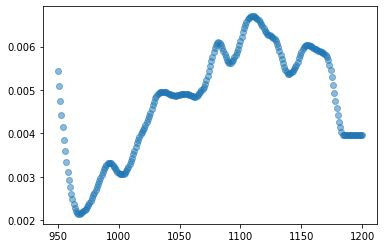

In [74]:
plot_glucose = glucose_180.loc[0]


plot_glucose = pd.DataFrame(plot_glucose.to_dict()).drop(columns='glucose')

plt.scatter(plot_glucose.wn_interpolated, plot_glucose.spectrum_interpolated, alpha=0.5)
plt.show()

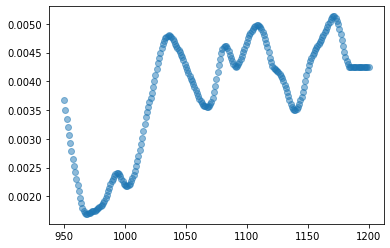

In [109]:
plot_glucose = glucose_180.loc[49]


plot_glucose = pd.DataFrame(plot_glucose.to_dict()).drop(columns='glucose')

plt.scatter(plot_glucose.wn_interpolated, plot_glucose.spectrum_interpolated, alpha=0.5)
plt.show()